# Loading the Data

In [1]:
import pandas as pd
from google.colab import drive
from transformers import ViTFeatureExtractor, ViTForImageClassification, AutoImageProcessor
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AdamW
from sklearn.model_selection import train_test_split
from torchvision import transforms
from tqdm import tqdm
import os
import numpy as np
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader,Dataset, TensorDataset
import torch.nn as nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/train.csv' train.csv
!cp '/content/drive/MyDrive/trainImages.zip' trainImages.zip
! unzip -q trainImages.zip
!cp '/content/drive/MyDrive/val.csv' val.csv
!cp '/content/drive/MyDrive/valImages.zip' valImages.zip
! unzip -q valImages.zip

In [5]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,not_offensive,not_motivational,neutral,Relationship status.\nSingle\nMarried\nIt's co...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,slight,not_motivational,neutral,Bernie or REAGAN?\nBe informed. Compare them o...
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,not_offensive,not_motivational,positive,I HEAR SOMETHING\nBetter run a mile\nOMG RAJ?\...
3,3,https://preview.redd.it/iwcz3o2niix61.jpg?widt...,very_funny,twisted_meaning,not_offensive,not_motivational,positive,Redditors Visiting IG memepages\n*dies from cr...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,not_funny,not_sarcastic,very_offensive,not_motivational,negative,"Samajh nahi aaya Par sun ke acabo,\nBUDGET SPE..."


In [6]:
df_val = pd.read_csv('val.csv', delimiter='\t')
df_val.head()

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,twisted_meaning,not_offensive,not_motivational,neutral,RVCJ\nwww.EVCI.COM\nTum paas aaye yun muskuray...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,general,slight,not_motivational,negative,"rukjao Maqbeol,\nbabuji ko tum nalt muaracay-\..."
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,very_negative,champak appreciating Jetha\nfor following lock...
3,3,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,negative,Noor Malik@ItsNoor 22h\nWhen you realize k\nNa...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,general,slight,not_motivational,neutral,noop\nαποταθεωρία\nNehe: ita gis having 5 boyf...


In [7]:
df_train.drop(columns=['overall','image_url'], inplace=True)
cat_replace = {'not_funny': 0, 'funny': 1, 'very_funny': 1, 'hilarious': 1}
df_train['humour'] = df_train['humour'].replace(cat_replace)
cat_replace = {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 1, 'very_twisted': 1}
df_train['sarcastic'] = df_train['sarcastic'].replace(cat_replace)
cat_replace = {'not_offensive': 0, 'slight': 1, 'very_offensive': 1, 'hateful_offensive': 1}
df_train['offensive'] = df_train['offensive'].replace(cat_replace)
cat_replace = {'not_motivational': 0, 'motivational': 1}
df_train['motivational'] = df_train['motivational'].replace(cat_replace)

df_val.drop(columns=['overall','image_url'], inplace=True)
cat_replace = {'not_funny': 0, 'funny': 1, 'very_funny': 1, 'hilarious': 1}
df_val['humour'] = df_val['humour'].replace(cat_replace)
cat_replace = {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 1, 'very_twisted': 1}
df_val['sarcastic'] = df_val['sarcastic'].replace(cat_replace)
cat_replace = {'not_offensive': 0, 'slight': 1, 'very_offensive': 1, 'hateful_offensive': 1}
df_val['offensive'] = df_val['offensive'].replace(cat_replace)
cat_replace = {'not_motivational': 0, 'motivational': 1}
df_val['motivational'] = df_val['motivational'].replace(cat_replace)

In [8]:
y_train = df_train.iloc[:,1:5]
y_val = df_val.iloc[:,1:5]

In [9]:
y_train = torch.tensor(np.array(y_train))
y_val = torch.tensor(np.array(y_val))

# Loading the BERT and ViT Models for Classification

In [17]:
# Extract captions and labels
train_captions = df_train['ocr'].tolist()
val_captions = df_val['ocr'].tolist()

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 500  # or another appropriate length

# Load pre-trained BERT
BERT_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
num_classes = 4
BERT_model.classifier = nn.Linear(BERT_model.config.hidden_size, num_classes)

# Training settings
BERT_model.to(device)
BERT_criterion = nn.BCEWithLogitsLoss()
BERT_optimizer = AdamW(BERT_model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
ViT_feature_extractor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
ViT_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
num_classes = 4
ViT_model.classifier = nn.Linear(ViT_model.config.hidden_size, num_classes)
ViT_criterion = nn.BCEWithLogitsLoss()
ViT_optimizer = optim.Adam(ViT_model.parameters(), lr=0.0001)

# Training the Model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

train_f1_overall = []
train_f1_humor = []
train_f1_sarcasm = []
train_f1_offensive = []
train_f1_motivation = []
train_loss = []
train_BERT_loss = []
train_ViT_loss = []

val_f1_overall = []
val_f1_humor = []
val_f1_sarcasm = []
val_f1_offensive = []
val_f1_motivation = []
val_loss = []
val_BERT_loss = []
val_ViT_loss = []

batch_size = 1
num_epochs = 5
train_idx = np.array(range(0, len(y_train)))
val_idx = np.array(range(0, len(y_val)))
np.random.seed(42)
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)
ViT_model = ViT_model.to(device)
for epoch in range(num_epochs):
  ViT_model.train()
  BERT_model.train()
  for batch_number, i in enumerate(range(0, len(y_train), batch_size)):
      i_end = min(i + batch_size, len(y_train))
      batch_idx = train_idx[i:i_end]
      labels = y_train[batch_idx].to(device)
      # Forward Pass for ViT
      images = [Image.open(f'/content/trainImages/{j}.jpg') for j in batch_idx]
      inputs = ViT_feature_extractor(images=images, return_tensors="pt").to(device)
      ViT_optimizer.zero_grad()
      outputs = ViT_model(**inputs)
      ViTlogits = outputs.logits
      ViTloss = ViT_criterion(ViTlogits, labels.float())
      ViTloss.backward()
      input_text = train_captions[i:i_end]
      inputs = tokenizer.encode_plus(
          input_text,
          add_special_tokens=True,
          max_length=500,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt'
      ).to(device)
      outputs = BERT_model(**inputs)
      BERTlogits = outputs.logits
      BERTloss = BERT_criterion(BERTlogits, labels.float())
      BERTloss.backward()
      BERT_optimizer.step()
      BERT_optimizer.zero_grad()
      BERTlogits = outputs.logits

      #print(BERTlogits.shape)
      #print(ViTlogits.shape)
      logits = torch.mean(torch.stack([BERTlogits, ViTlogits], dim=0), dim=0)
      #print(logits)

      # Get Overall F1 Score
      predictions = (torch.sigmoid(logits) > 0.5).float()
      predictions_flat = predictions.view(-1)
      labels_flat = labels.view(-1)
      f1_overall = f1_score(labels_flat.detach().cpu().numpy(), predictions_flat.detach().cpu().numpy(), average='binary')
      if(batch_number % 100 == 0):
        print(f"Epoch {epoch + 1}, Batch {batch_number + 1}, F1 Score: {f1_overall:.4f}, Loss: {ViTloss.item()+BERTloss.item()}")
        train_f1_overall.append(f1_overall)
        train_loss.append(ViTloss.item()+BERTloss.item())
        train_BERT_loss.append(BERTloss.item())
        train_ViT_loss.append(ViTloss.item())
        # Split the predictions and labels into the 4 individual categories: humor, sarcasm, offensive, motivational
        split_predictions = torch.split(predictions, 1, dim=1)
        predictions_humor, predictions_sarcasm, predictions_offensive, predictions_motivation = split_predictions
        split_labels = torch.split(labels, 1, dim=1)
        labels_humor, labels_sarcasm, labels_offensive, labels_motivation = split_labels
        # Get Humor F1 Score
        predictions_humor_flat = predictions_humor.view(-1)
        labels_humor_flat = labels_humor.view(-1)
        f1_humor = f1_score(labels_humor_flat.detach().cpu().numpy(), predictions_humor_flat.detach().cpu().numpy(), average='binary', zero_division=0)
        train_f1_humor.append(f1_humor)
        # Get Sarcasm F1 Score
        predictions_sarcasm_flat = predictions_sarcasm.view(-1)
        labels_sarcasm_flat = labels_sarcasm.view(-1)
        f1_sarcasm = f1_score(labels_sarcasm_flat.detach().cpu().numpy(), predictions_sarcasm_flat.detach().cpu().numpy(), average='binary', zero_division=0)
        train_f1_sarcasm.append(f1_sarcasm)
        # Get Offensive F1 Score
        predictions_offensive_flat = predictions_offensive.view(-1)
        labels_offensive_flat = labels_offensive.view(-1)
        f1_offensive = f1_score(labels_offensive_flat.detach().cpu().numpy(), predictions_offensive_flat.detach().cpu().numpy(), average='binary', zero_division=0)
        train_f1_offensive.append(f1_offensive)
        # Get Motivational F1 Score
        predictions_motivation_flat = predictions_motivation.view(-1)
        labels_motivation_flat = labels_motivation.view(-1)
        f1_motivation = f1_score(labels_motivation_flat.detach().cpu().numpy(), predictions_motivation_flat.detach().cpu().numpy(), average='binary', zero_division=0)
        train_f1_motivation.append(f1_motivation)

  # Run validation after each epoch
  ViT_model.eval()
  BERT_model.eval()
  val_f1_overall_epoch = []
  val_f1_humor_epoch = []
  val_f1_sarcasm_epoch = []
  val_f1_offensive_epoch = []
  val_f1_motivation_epoch = []
  val_loss_epoch = []
  val_BERT_loss_epoch = []
  val_ViT_loss_epoch = []
  for batch_number, i in enumerate(range(0, len(y_val), batch_size)):
    # Make predictions on validation set
    i_end = min(i + batch_size, len(y_val))
    batch_idx = val_idx[i:i_end]
    labels = y_val[batch_idx].to(device)
    images = [Image.open(f'/content/trainImages/{j}.jpg') for j in batch_idx]
    inputs = ViT_feature_extractor(images=images, return_tensors="pt").to(device)
    outputs = ViT_model(**inputs)
    ViTlogits = outputs.logits
    input_text = train_captions[i:i_end]
    inputs = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=500,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    ).to(device)
    outputs = BERT_model(**inputs)
    BERTlogits = outputs.logits
    logits = torch.mean(torch.stack([BERTlogits, ViTlogits], dim=0), dim=0)
    predictions = (torch.sigmoid(logits) > 0.5).float()
    predictions_flat = predictions.view(-1)
    labels_flat = labels.view(-1)
    ViTloss = ViT_criterion(ViTlogits, labels.float())
    BERTloss = BERT_criterion(BERTlogits, labels.float())
    f1_overall = f1_score(labels_flat.detach().cpu().numpy(), predictions_flat.detach().cpu().numpy(), average='binary')
    val_f1_overall_epoch.append(f1_overall)
    val_loss_epoch.append(ViTloss.item()+BERTloss.item())
    val_BERT_loss_epoch.append(BERTloss.item())
    val_ViT_loss_epoch.append(ViTloss.item())
    # Split the predictions and labels into the 4 individual categories: humor, sarcasm, offensive, motivational
    split_predictions = torch.split(predictions, 1, dim=1)
    predictions_humor, predictions_sarcasm, predictions_offensive, predictions_motivation = split_predictions
    split_labels = torch.split(labels, 1, dim=1)
    labels_humor, labels_sarcasm, labels_offensive, labels_motivation = split_labels
    # Get Humor F1 Score
    predictions_humor_flat = predictions_humor.view(-1)
    labels_humor_flat = labels_humor.view(-1)
    f1_humor = f1_score(labels_humor_flat.detach().cpu().numpy(), predictions_humor_flat.detach().cpu().numpy(), average='binary', zero_division=0)
    val_f1_humor_epoch.append(f1_humor)
    # Get Sarcasm F1 Score
    predictions_sarcasm_flat = predictions_sarcasm.view(-1)
    labels_sarcasm_flat = labels_sarcasm.view(-1)
    f1_sarcasm = f1_score(labels_sarcasm_flat.detach().cpu().numpy(), predictions_sarcasm_flat.detach().cpu().numpy(), average='binary', zero_division=0)
    val_f1_sarcasm_epoch.append(f1_sarcasm)
    # Get Offensive F1 Score
    predictions_offensive_flat = predictions_offensive.view(-1)
    labels_offensive_flat = labels_offensive.view(-1)
    f1_offensive = f1_score(labels_offensive_flat.detach().cpu().numpy(), predictions_offensive_flat.detach().cpu().numpy(), average='binary', zero_division=0)
    val_f1_offensive_epoch.append(f1_offensive)
    # Get Motivational F1 Score
    predictions_motivation_flat = predictions_motivation.view(-1)
    labels_motivation_flat = labels_motivation.view(-1)
    f1_motivation = f1_score(labels_motivation_flat.detach().cpu().numpy(), predictions_motivation_flat.detach().cpu().numpy(), average='binary', zero_division=0)
    val_f1_motivation_epoch.append(f1_motivation)

  val_loss.append(np.mean(val_loss_epoch))
  val_BERT_loss.append(np.mean(val_BERT_loss_epoch))
  val_ViT_loss.append(np.mean(val_ViT_loss_epoch))
  val_f1_overall.append(np.mean(val_f1_overall_epoch))
  val_f1_humor.append(np.mean(val_f1_humor_epoch))
  val_f1_sarcasm.append(np.mean(val_f1_sarcasm_epoch))
  val_f1_offensive.append(np.mean(val_f1_offensive_epoch))
  val_f1_motivation.append(np.mean(val_f1_motivation_epoch))

  print(f"Epoch {epoch + 1}, Average Validation F1 Score: {np.mean(val_f1_overall_epoch):.4f}")

Epoch 1, Batch 1, F1 Score: 0.6667, Loss: 1.2286087274551392
Epoch 1, Batch 101, F1 Score: 0.8000, Loss: 1.253919780254364
Epoch 1, Batch 201, F1 Score: 0.6667, Loss: 1.2468540370464325
Epoch 1, Batch 301, F1 Score: 1.0000, Loss: 0.9303982853889465
Epoch 1, Batch 401, F1 Score: 1.0000, Loss: 0.8234855532646179
Epoch 1, Batch 501, F1 Score: 0.0000, Loss: 2.161351203918457
Epoch 1, Batch 601, F1 Score: 1.0000, Loss: 0.9428775310516357
Epoch 1, Batch 701, F1 Score: 0.8000, Loss: 1.4259326457977295
Epoch 1, Batch 801, F1 Score: 0.8000, Loss: 1.1099677681922913
Epoch 1, Batch 901, F1 Score: 0.8000, Loss: 1.1344231367111206
Epoch 1, Batch 1001, F1 Score: 0.8000, Loss: 1.0087080597877502
Epoch 1, Batch 1101, F1 Score: 0.6667, Loss: 1.6844438314437866
Epoch 1, Batch 1201, F1 Score: 0.6667, Loss: 1.212328553199768
Epoch 1, Batch 1301, F1 Score: 0.6667, Loss: 1.4050599336624146
Epoch 1, Batch 1401, F1 Score: 0.8000, Loss: 1.4281609058380127
Epoch 1, Batch 1501, F1 Score: 1.0000, Loss: 0.77490144

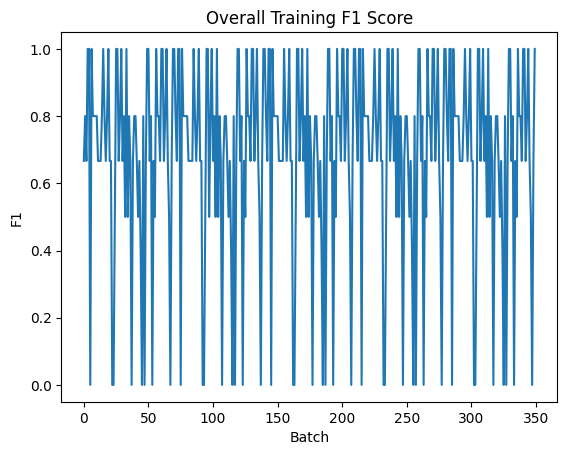

In [36]:
import matplotlib .pyplot as plt

plt.plot(np.array(range(len(train_f1_overall))), train_f1_overall)
plt.title('Overall Training F1 Score')
plt.xlabel('Batch')
plt.ylabel('F1')
plt.show()

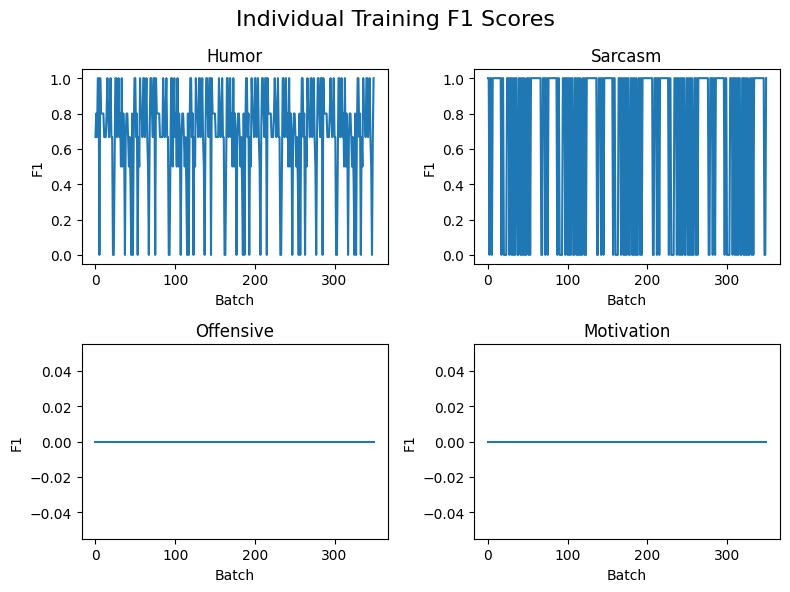

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Individual Training F1 Scores', fontsize=16)

axs[0, 0].plot(np.array(range(len(train_f1_humor))), train_f1_overall, label='Humor')
axs[0, 0].set_title('Humor')
axs[0, 0].set_xlabel('Batch')
axs[0, 0].set_ylabel('F1')

axs[0, 1].plot(np.array(range(len(train_f1_sarcasm))), train_f1_sarcasm, label='Sarcasm')
axs[0, 1].set_title('Sarcasm')
axs[0, 1].set_xlabel('Batch')
axs[0, 1].set_ylabel('F1')

axs[1, 0].plot(np.array(range(len(train_f1_offensive))), train_f1_offensive, label='Offensive')
axs[1, 0].set_title('Offensive')
axs[1, 0].set_xlabel('Batch')
axs[1, 0].set_ylabel('F1')

axs[1, 1].plot(np.array(range(len(train_f1_motivation))), train_f1_motivation, label='Motivation')
axs[1, 1].set_title('Motivation')
axs[1, 1].set_xlabel('Batch')
axs[1, 1].set_ylabel('F1')

plt.tight_layout()

# Show the plot
plt.show()

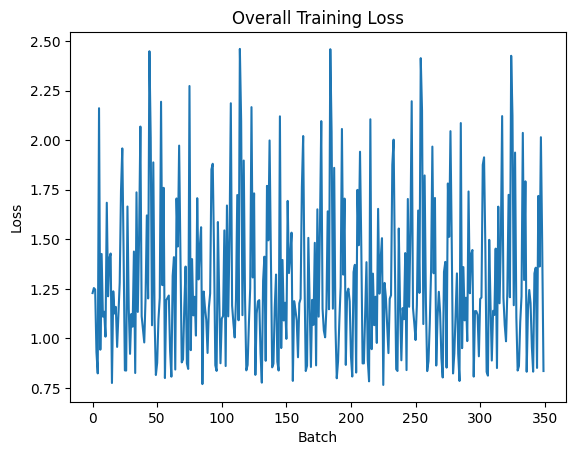

In [42]:
plt.plot(np.array(range(len(train_loss))), train_loss)
plt.title('Overall Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

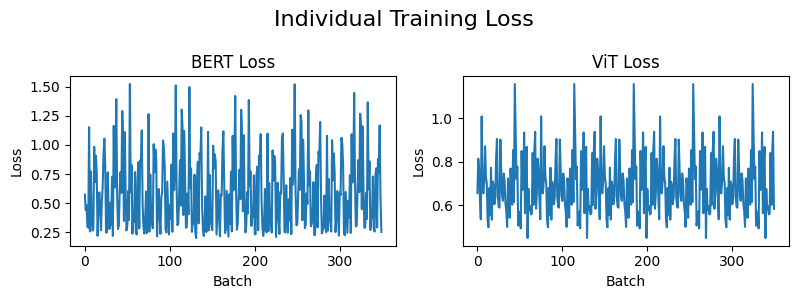

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Individual Training Loss', fontsize=16)

axs[0].plot(np.array(range(len(train_BERT_loss))), train_BERT_loss)
axs[0].set_title('BERT Loss')
axs[0].set_xlabel('Batch')
axs[00].set_ylabel('Loss')

axs[1].plot(np.array(range(len(train_ViT_loss))), train_ViT_loss)
axs[1].set_title('ViT Loss')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')

plt.tight_layout()

# Show the plot
plt.show()

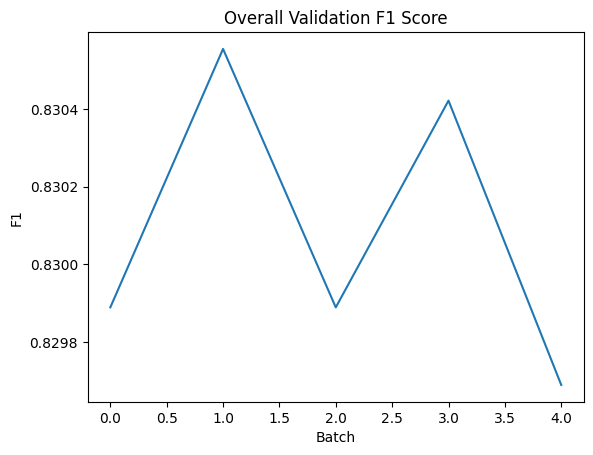

In [40]:
import matplotlib .pyplot as plt

plt.plot(np.array(range(len(val_f1_overall))), val_f1_overall)
plt.title('Overall Validation F1 Score')
plt.xlabel('Batch')
plt.ylabel('F1')
plt.show()

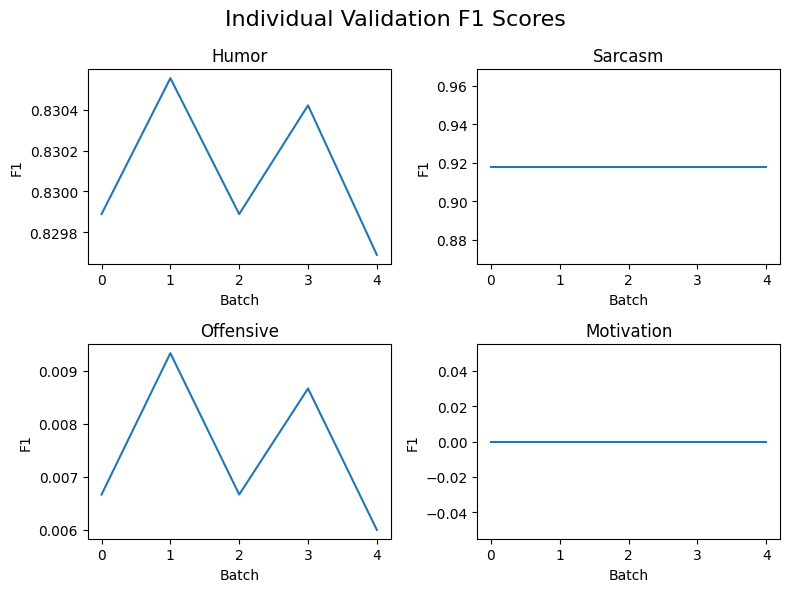

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Individual Validation F1 Scores', fontsize=16)

axs[0, 0].plot(np.array(range(len(val_f1_humor))), val_f1_overall, label='Humor')
axs[0, 0].set_title('Humor')
axs[0, 0].set_xlabel('Batch')
axs[0, 0].set_ylabel('F1')

axs[0, 1].plot(np.array(range(len(val_f1_sarcasm))), val_f1_sarcasm, label='Sarcasm')
axs[0, 1].set_title('Sarcasm')
axs[0, 1].set_xlabel('Batch')
axs[0, 1].set_ylabel('F1')

axs[1, 0].plot(np.array(range(len(val_f1_offensive))), val_f1_offensive, label='Offensive')
axs[1, 0].set_title('Offensive')
axs[1, 0].set_xlabel('Batch')
axs[1, 0].set_ylabel('F1')

axs[1, 1].plot(np.array(range(len(val_f1_motivation))), val_f1_motivation, label='Motivation')
axs[1, 1].set_title('Motivation')
axs[1, 1].set_xlabel('Batch')
axs[1, 1].set_ylabel('F1')

plt.tight_layout()

# Show the plot
plt.show()

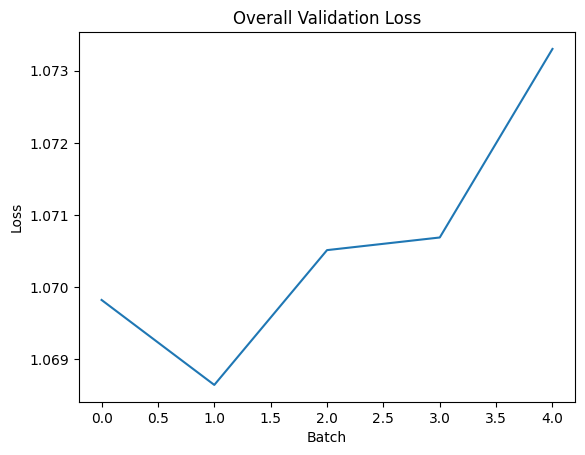

In [43]:
plt.plot(np.array(range(len(val_loss))), val_loss)
plt.title('Overall Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

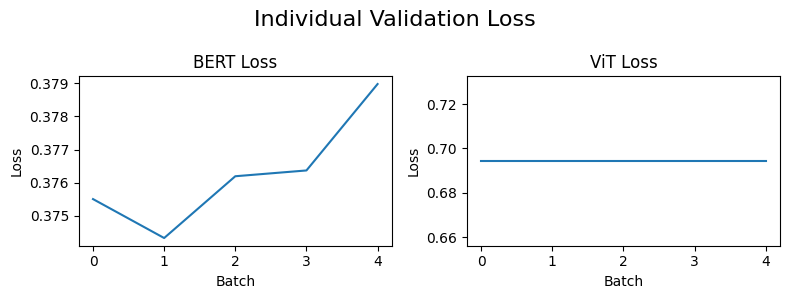

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Individual Validation Loss', fontsize=16)

axs[0].plot(np.array(range(len(val_BERT_loss))), val_BERT_loss)
axs[0].set_title('BERT Loss')
axs[0].set_xlabel('Batch')
axs[00].set_ylabel('Loss')

axs[1].plot(np.array(range(len(val_ViT_loss))), val_ViT_loss)
axs[1].set_title('ViT Loss')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')

plt.tight_layout()

# Show the plot
plt.show()